In [1]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# EDA - Instacart data

### what this is
1. Quick look at what's in the data
2. Checking for red flags
3. Looking for exploitable trends in the data


### Data Definition

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


In [2]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [3]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [4]:
# aliases for easy typing
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

In [5]:
orders.count()

user_id                   414772
order_number              414772
order_dow                 414772
order_hour_of_day         414772
days_since_prior_order    389772
dtype: int64

In [6]:
len(db['order_products']['order_id'].unique())

389772

In [7]:
orders_

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,
2168274,2,1,2,11,NaN
1501582,2,2,5,10,10.0
1901567,2,3,1,10,3.0
738281,2,4,2,10,8.0
1673511,2,5,3,11,8.0
1199898,2,6,2,9,13.0
3194192,2,7,2,12,14.0
788338,2,8,1,15,27.0
1718559,2,9,2,9,8.0


In [8]:
db['order_products'][ops['order_id'] == 1492625]  # last order by customer no. 2

,order_id,product_id,add_to_cart_order,reordered


see above: ^

### Order_products does not include the last order by any customer



for ease of use:

### Build (flat) order details table:

In [9]:
ops.columns, orders.columns, products.columns

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object'),
 Index(['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 Index(['product_name', 'aisle_id', 'department_id'], dtype='object'))

In [10]:
order_details = pd.merge(ops, orders, left_on='order_id', right_index=True)
order_details.head()   # needs product info for ease of use

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,3,5,9,8.0
1,2,28985,2,1,202279,3,5,9,8.0
2,2,9327,3,0,202279,3,5,9,8.0
3,2,45918,4,1,202279,3,5,9,8.0
4,2,30035,5,0,202279,3,5,9,8.0


In [11]:
order_details = pd.merge(order_details, products, left_on='product_id', right_index=True)

# Analysis:

## Topics

Breakdowns by:

1. Product (most popular, least)
2. Departments 
3. Aisles

3. Customers
4. Timing (week, day)
5. Item order: what % of times that a product is ordered is it the first or last item ordered?
6. Products: predictions/suggestions for next product added to cart

# Quick look at the shape of the data

In [12]:
%matplotlib inline

Text(0,0.5,'')

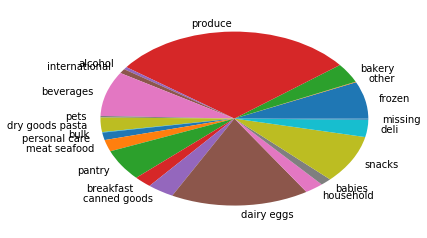

In [13]:
fig, ax = plt.subplots()

dept_sales = order_details.groupby('department_id').product_id.size()
ax = dept_sales.plot.pie(y='department_id', legend=False, labels=db['departments'].department)
ax.set_ylabel('')

24 = fresh fruits
83 = fresh vegetables
123 = packaged vegetables fruits
120 = yogurt
21 = packaged cheese
84 = milk
115 = water seltzer sparkling water
107 = chips pretzels
91 = soy lactosefree
112 = bread
31 = refrigerated
116 = frozen produce


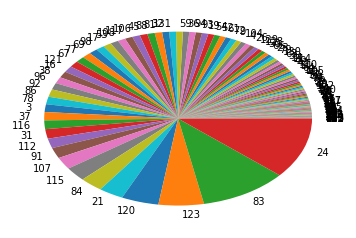

In [14]:
fig, ax = plt.subplots()

aisle_sales = order_details.groupby('aisle_id').product_id.size().sort_values()
ax = aisle_sales.plot.pie(y='aisle_id', legend=False)
ax.set_ylabel('')

for i in range(12):
    which = aisle_sales.index[-1-i]
    print('{} = {}'.format(which, db['aisles'].aisle.loc[which]))

<module 'matplotlib.pyplot' from '/home/sam/.envs/instacart/lib/python3.5/site-packages/matplotlib/pyplot.py'>

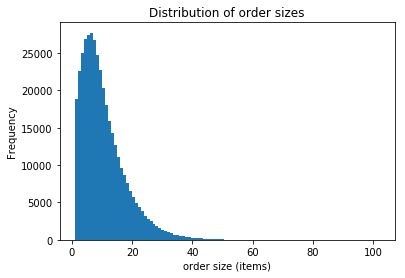

In [15]:
ax = ops.groupby('order_id').size().plot.hist(bins=102)
ax.set_xlabel('order size (items)')
ax.set_title('Distribution of order sizes')
plt

Text(0.5,1,'Orders per customer')

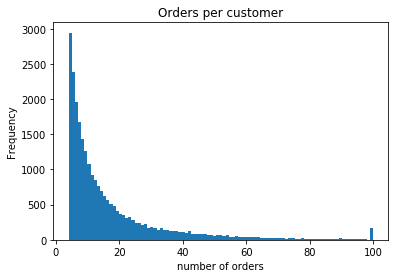

In [16]:
ax = orders.groupby('user_id').size().plot.hist(bins=97)  # tail accumulates at 100
ax.set_xlabel('number of orders')
ax.set_title('Orders per customer')

# distribution of popular products

percent of orders made up by top products

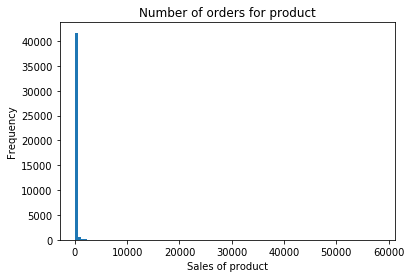

In [17]:
ax = ops.groupby('product_id').size().plot.hist(bins=100)
ax.set_xlabel('Sales of product')
ax.set_title('Number of orders for product')
plt.show()

In [18]:
sum(order_details.product_id.value_counts()[:10]) / len(ops) 
# top 10 (of 50k) products: % of order items

0.07206760406015819

In [19]:
sum(order_details.product_id.value_counts()[:100]) / len(ops) 
# top 100 (of 50k) products: % of order items

0.2313904318989711

In [20]:
sum(order_details.product_id.value_counts()[:1000]) / len(ops) 
# top 1000 (of 50k) products: % of order items

0.5430262797072625

In [21]:
sum(order_details.product_id.value_counts()[:10000]) / len(ops) 
# top 20% (of 50k) products: % of order items

0.9142364470251706

# What percent of orders for a product are reorders?

If a product is never reordered or negatively affects customer retrention, this is a problem (that is easy to solve).

In [22]:
tmp = pd.DataFrame({'reorder_pct': ops.groupby('product_id').reordered.mean(),
                    'num_orders': order_details.groupby('product_id').size()})

In [23]:
order_details = pd.merge(order_details, tmp, left_on='product_id', right_index=True)

department    produce
Name: 4, dtype: object


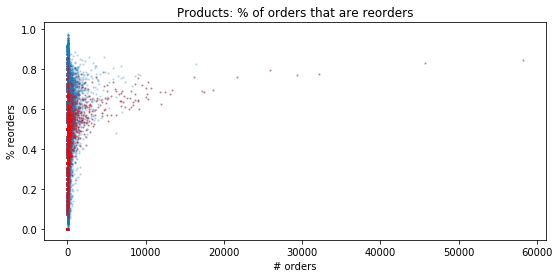

In [24]:
# plot percentage reorders by department
fig, ax = plt.subplots()
dept_id = 4

print(db['departments'].loc[dept_id])

fig.set_size_inches(9,4)
ax.scatter(order_details.groupby('product_id').size(), 
           order_details.groupby('product_id').reorder_pct.mean(),
           s=2,
           alpha=.2,)

ax.scatter(order_details[order_details.department_id == 4].groupby('product_id').size(), 
           order_details[order_details.department_id == 4].groupby('product_id').reorder_pct.mean(),
           s=1,
           color='red',
           alpha=.3,)

ax.set_xlabel('# orders')
ax.set_ylabel('% reorders')
ax.set_title('Products: % of orders that are reorders')
plt.show()

# What is the outlier below mass of data points? x ~= 6300

It is... olive oil. Seems reasonable

In [25]:
products = pd.merge(products, tmp, left_index=True, right_index=True)  # add reorder/num_orders to products table

In [27]:
products[products.num_orders < 6500].sort_values('num_orders', ascending=False)[:10]

,product_name,aisle_id,department_id,num_orders,reorder_pct
product_id,,,,,
24838,Unsweetened Almondmilk,91,16,6418,0.764101
25890,Boneless Skinless Chicken Breasts,49,12,6236,0.662765
31506,Extra Virgin Olive Oil,19,13,6230,0.480738
46667,Organic Ginger Root,83,4,6218,0.570601
22825,Organic D'Anjou Pears,24,4,6199,0.690595
39928,Organic Kiwi,24,4,6044,0.703342
35221,Lime Sparkling Water,115,7,5803,0.748578
12341,Hass Avocados,32,4,5796,0.734990
5785,Organic Reduced Fat 2% Milk,84,16,5777,0.805262


In [28]:
products[products.product_name.str.lower().str.contains('olive oil')].__len__()

253

# User information

Compile some stats about users from order info. Trend of user # of orders vs. size of orders is fairly flat (trends toward center). Not surprising in retrospect.

In [29]:
users = pd.DataFrame({'num_orders': orders.groupby('user_id').size()})
len(users)

25000

In [30]:
users['total_products_ordered'] = order_details.groupby('user_id').size()  # total products ordered by user

In [31]:
users['mean_order_size'] = users.total_products_ordered / users.num_orders

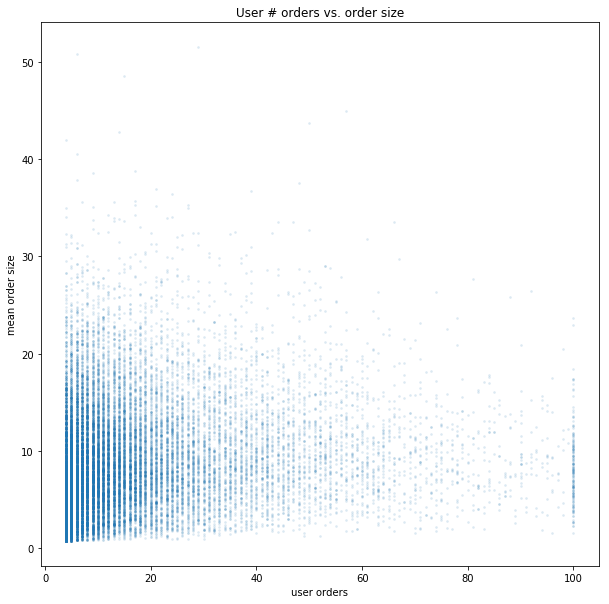

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(x=users.num_orders, y=users.mean_order_size, s=3, alpha=.1)
ax.set_xlabel('user orders')
ax.set_ylabel('mean order size')
ax.set_title('User # orders vs. order size')
plt.show()

# Time

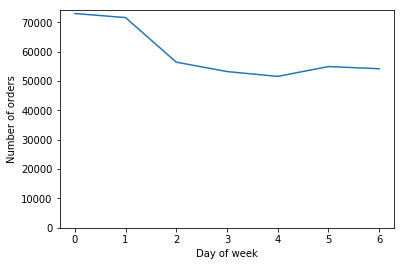

In [33]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
plt.show()

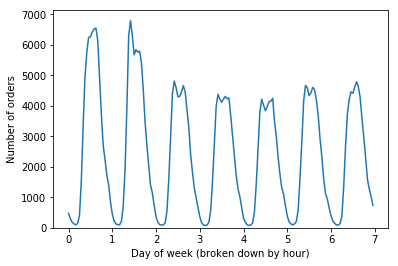

In [34]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week (broken down by hour)')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))
plt.show()

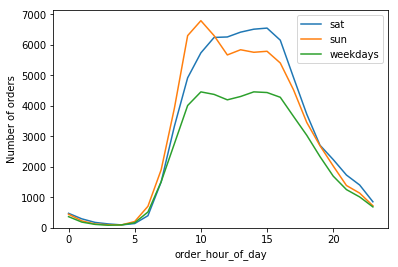

In [35]:
ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='weekdays')
ax.set_ybound(0)
ax.legend()
plt.show()

### Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

# product time groups:

Do products vary significantly in terms of:
- order time
- cart add order


Make a column for cart add order: order_position_pct

In [36]:
tmp = pd.DataFrame({'order_size': order_details.groupby('order_id').size()})   # number of items in an order

In [37]:
order_details = pd.merge(order_details, tmp, left_on='order_id', right_index=True)

In [38]:
order_details['order_position_pct'] = order_details.add_to_cart_order / order_details.order_size

In [39]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,num_orders,reorder_pct,order_size,order_position_pct
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16,2506,0.723464,9,0.111111
1,2,28985,2,1,202279,3,5,9,8.0,Michigan Organic Kale,83,4,8192,0.691650,9,0.222222
2,2,9327,3,0,202279,3,5,9,8.0,Garlic Powder,104,13,774,0.139535,9,0.333333
3,2,45918,4,1,202279,3,5,9,8.0,Coconut Butter,19,13,98,0.306122,9,0.444444
4,2,30035,5,0,202279,3,5,9,8.0,Natural Sweetener,17,13,34,0.352941,9,0.555556


In [40]:
cart_adds = order_details[order_details.num_orders >= 1000].groupby('product_id')['order_position_pct'].mean().sort_values()
cart_adds[:10]

product_id
39180    0.372177
45504    0.377191
43394    0.378304
38689    0.390259
29447    0.394541
24852    0.398687
13166    0.401335
24024    0.404682
1463     0.414550
1511     0.414968
Name: order_position_pct, dtype: float64

In [41]:
products.loc[cart_adds.index[-10:].values]   # 10 latest-added products

,product_name,aisle_id,department_id,num_orders,reorder_pct
product_id,,,,,
32691,Vanilla Ice Cream,37,1,1610,0.529814
7503,Whole Almonds,117,19,1506,0.561089
31066,Aluminum Foil,85,17,1228,0.193811
13535,Organic Medium Salsa,51,13,1768,0.509050
44628,Organic Dijon Mustard,72,13,1341,0.260254
24009,Organic Long Grain White Rice,63,9,1104,0.409420
5068,Cauliflower Florets,32,4,1033,0.552759
46149,Zero Calorie Cola,77,7,1036,0.804054
21195,Organic Extra Virgin Olive Oil,19,13,1632,0.521446


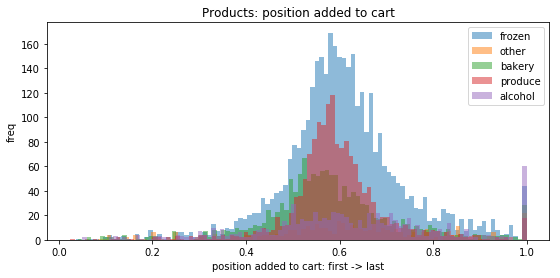

In [42]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(1, 6):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

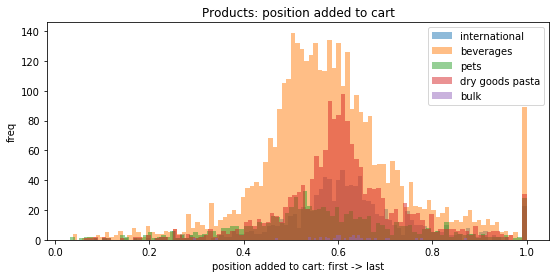

In [43]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(6, 11):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

# lesson of cart_add_order: 

People put junk food, booze, etc. in their cart at the end. If we know/suspect a shopper is almost done shopping, it could be an opportunity to add on guilty-pleasure type products.

# opposite: what products get added first?

In [67]:
products.loc[cart_adds.index[:10].values]   # 10 first added products

,product_name,aisle_id,department_id,num_orders,reorder_pct
product_id,,,,,
39180,Organic Lowfat 1% Milk,84,16,1910,0.844503
45504,Whole Organic Omega 3 Milk,84,16,1005,0.834826
43394,Organic Lactose Free Whole Milk,91,16,1188,0.869529
38689,Organic Reduced Fat Milk,84,16,4738,0.859434
29447,"Milk, Organic, Vitamin D",84,16,2730,0.862271
24852,Banana,24,4,58231,0.845941
13166,"Organic Milk Reduced Fat, 2% Milkfat",84,16,1561,0.850096
24024,1% Lowfat Milk,84,16,1956,0.827198
1463,Organic Milk,84,16,3529,0.814395


In [46]:
order_details = pd.merge(order_details, 
                pd.DataFrame({'times_added_first': order_details[order_details.add_to_cart_order == 1].groupby('product_id').size()}),
                right_index=True,
                left_on='product_id')

In [47]:
order_details['pct_added_first'] = order_details.times_added_first / order_details.num_orders

# Reorder time series

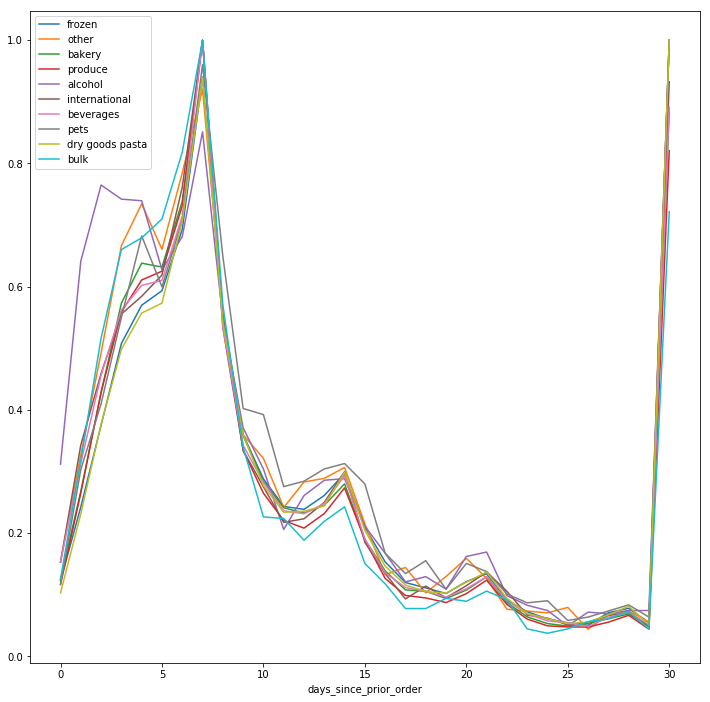

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('days_since_prior_order').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

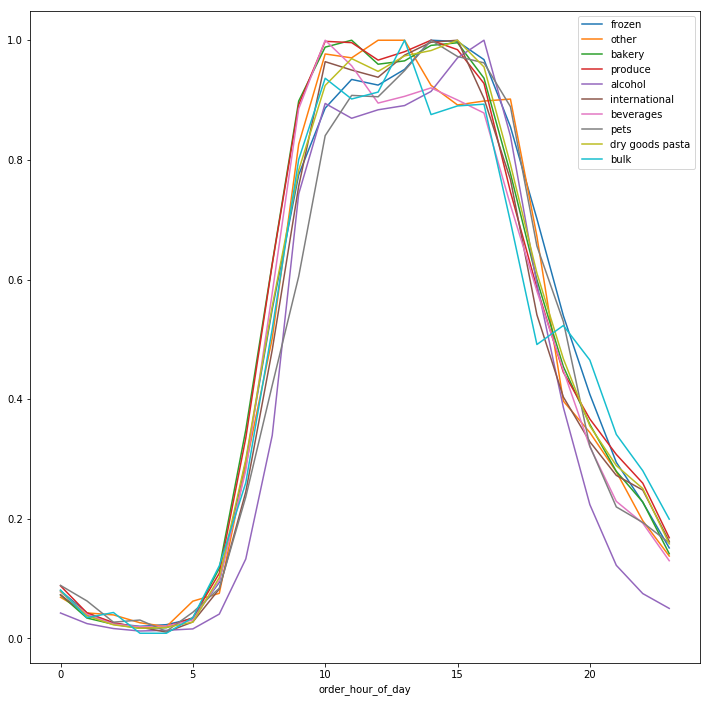

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [62]:
order_details.groupby('aisle_id')['order_hour_of_day'].mean().sort_values()[:5]

aisle_id
125    12.884017
46     12.944597
11     13.015354
32     13.017249
10     13.053254
Name: order_hour_of_day, dtype: float64

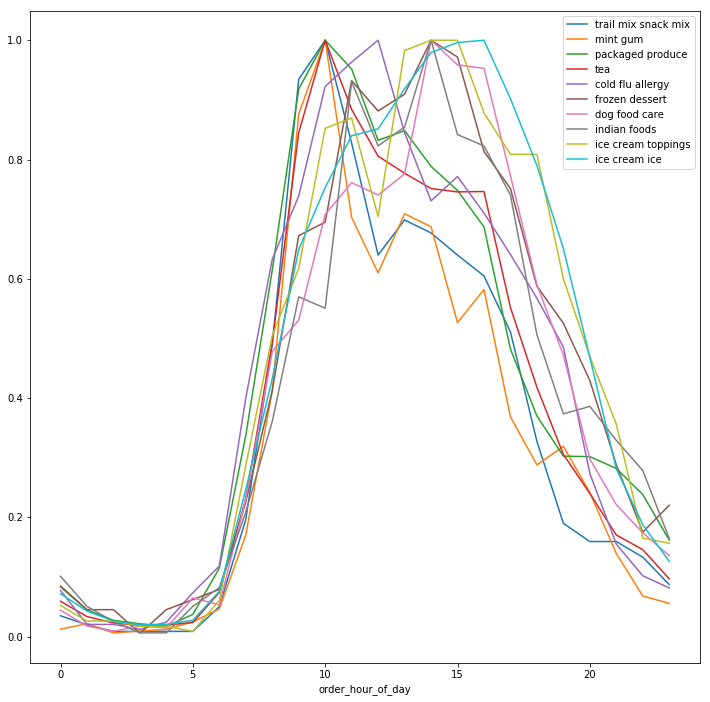

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in [125, 46, 32, 94, 11, 119, 40, 76, 103, 37]:
    series = order_details[order_details.aisle_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['aisles'].aisle.loc[i])

ax.legend()
plt.show()
# earliest vs. latest product